In [1]:
# -*- coding:utf8 -*-
# @TIME : 2018/4/26 下午6:15
# @Author : Allen
# @File : product_search_relevance.py

#目的：给出输入关键字与搜索结果，评价搜索准确度

#处理思路
#1，导入包、数据  -> 合并数据格式concat,merge,
#2，文本预处理 -> 【简单方法】：看输入词是在搜索结果中出现几次，需要先统一数据集格式 -> str_stemmer and str_commond_words 处理数据
#3，自制文本特征 -> 关键词长度/搜索词语与title和describtion中重复词语数 -> 去掉之前的英文，保留自制特征
#4，重塑训练／测试集 -> 拆分出X_train, X_test, y_train, 去除label
#5，建立模型：Ridge回归模型RandomForestRegressor 找出最佳参数max_depth=7 通过多种参数导入 -> 画图
#6，上传结果：生成csv文件

In [2]:
#1) 导入需要用的库
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
import os
os.chdir('/Users/a1/Desktop/算法实战/Word2vec/Product_search_relevance/data')


In [3]:
#读取数据
df_train = pd.read_csv('train.csv', encoding = "ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding = "ISO-8859-1")
df_desc = pd.read_csv('product_descriptions.csv')

In [6]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [7]:
df_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [8]:
#合并测试集与训练集，便于统一文本预处理
#PANDAS 数据合并与重塑（concat篇）：https://blog.csdn.net/stevenkwong/article/details/52528616
#PANDAS 数据合并与重塑（join/merge篇）:https://blog.csdn.net/stevenkwong/article/details/52540605
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all.head()
#print(df_all.shape)

,id,product_title,product_uid,relevance,search_term
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet


In [9]:
#把描述信息加入表，how='left'表示左边全部保留，on表示以什么为基准对齐
df_all = pd.merge(df_all, df_desc, how='left', on='product_uid')
df_all.head()
#print("******************************")

,id,product_title,product_uid,relevance,search_term,product_description
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ..."
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ..."
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...


In [10]:
#2) 文本预处理，把表格的语句处理为计算机能懂的格式，这里使用NLTK
stemmer = SnowballStemmer('english')
#这里简单处理，只提取了词干
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])
#计算"关键词次数"
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [11]:
#把每一个column都跑一遍，用str_stemmer清洁所有的文本内容
df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

In [14]:
#3） 自制文本特征
#关键字的长度
df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)
#搜索词与标题中有多少关键字重合
df_all['commons_in_title'] = df_all.apply(lambda x:str_common_word(x['search_term'], x['product_title']), axis=1)
#搜索词与描述中有多少关键字重合
#df_all['commons_in_desc'] = df_all.apply(lambda x: str_common_word(x['search_term'], x['product_description'], axis = 1)
df_all['commons_in_desc'] = df_all.apply(lambda x: str_common_word(x['search_term'], x['product_description']), axis=1)
#搞完之后，我们把不能被『机器学习模型』处理的column给drop掉,这一步太偷懒了
df_all = df_all.drop(['search_term', 'product_title', 'product_description'], axis=1)


In [22]:
df_all.head(20)

,id,product_uid,relevance,len_of_query,commons_in_title,commons_in_desc
0,2,100001,3.00,2,1,1
1,3,100001,2.50,2,1,1
2,9,100002,3.00,2,1,1
3,16,100005,2.33,3,1,1
4,17,100005,2.67,3,3,2
5,18,100006,3.00,2,1,2
6,20,100006,2.67,3,2,2
7,21,100006,3.00,1,1,1
8,23,100007,2.67,2,2,2
9,27,100009,3.00,2,2,2


In [15]:
#4) 重塑训练／测试集合， 刚才把train与test合并了，现在分开
df_train = df_all.loc[df_train.index]
df_test = df_all.loc[df_test.index]
#记录id，后续上传能用
test_ids = df_test['id']
#分离出y_train
y_train = df_train['relevance'].values
#删除原集合中的label
X_train = df_train.drop(['id', 'relevance'], axis=1).values
X_test = df_test.drop(['id', 'relevance'], axis=1).values
print("###################")

###################


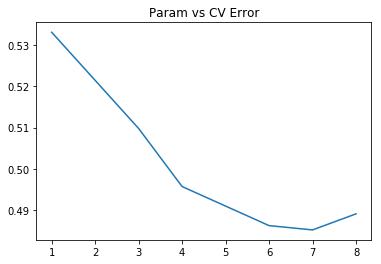

In [20]:
#5)建立模型：Ridge模型
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
%matplotlib inline
params = [1, 3, 4, 6, 7, 8,]
test_scores = []
for param in params:
    clf = RandomForestRegressor(n_estimators=30, max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

import matplotlib.pyplot as plt
plt.plot(params, test_scores)
plt.title("Param vs CV Error");



In [24]:
#6) 上传结果
rf = RandomForestRegressor(n_estimators=30, max_depth=7)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [25]:
y_pred = rf.predict(X_test)

In [26]:
pd.DataFrame({"id": test_ids, "relevance": y_pred}).to_csv('submission123.csv',index=False)